In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database

import dpmhm
from dpmhm.datasets import transformer, preprocessing, feature, utils

2024-06-11 11:39:35.367816: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 11:39:35.371599: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 11:39:35.427296: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 11:39:36.371910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
TFDS_DATA_DIR = os.path.expanduser('~/tensorflow_datasets/')

In [3]:
# !cd ~/Téléchargements
# !pwd
# !ls
# !unzip /mfpt.zip
# !mv MFPT\ Fault\ Data\ Sets/ ../tmp/

In [4]:
_ = dpmhm.datasets.install('MFPT', 
                            data_dir=TFDS_DATA_DIR,                           
                            manual_dir=os.path.expanduser('~/tmp/MFPT Fault Data Sets/')
                          )

2024-06-11 11:39:38.469594: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-11 11:39:38.469625: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: is230816
2024-06-11 11:39:38.469634: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: is230816
2024-06-11 11:39:38.469769: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.171.4
2024-06-11 11:39:38.469795: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.171.4
2024-06-11 11:39:38.469802: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 535.171.4


In [5]:
dataset_name = 'MFPT'

ds_all, ds_info = tfds.load(
    dataset_name, 
    data_dir=TFDS_DATA_DIR,
    # split=['train[:75%]', 'train[75%:]'],   
    # split=['all'],
    with_info=True,
    # batch_size=-1,  # load the whole dataset into a single batch
)

print(ds_all.keys())  # show the split of the raw dataset

ds0 = ds_all['train']

dict_keys(['train'])


In [6]:
ds0.cardinality().numpy()

20

In [7]:
eles = list(ds0.take(ds0.cardinality().numpy()).as_numpy_iterator())

# for x, el in enumerate(eles):
#     print(el['metadata']['LoadForce'],el['metadata']['FileName'])

2024-06-11 11:39:38.750933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


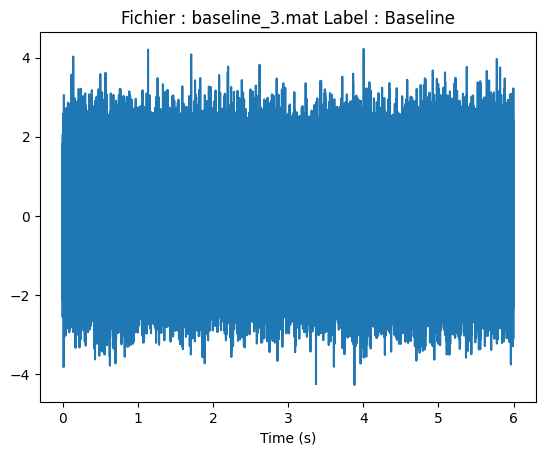

In [8]:
fn = eles[12]['metadata']['FileName'].decode()
sr = eles[12]['sampling_rate']
x = eles[12]['signal']['sig']
label=eles[12]['metadata']['Label'].decode()

plt.figure()
plt.plot(np.arange(len(x))/sr, x)
plt.xlabel('Time (s)')
plt.title('Fichier : '+fn+' Label : '+label)

Audio(x, rate=sr)

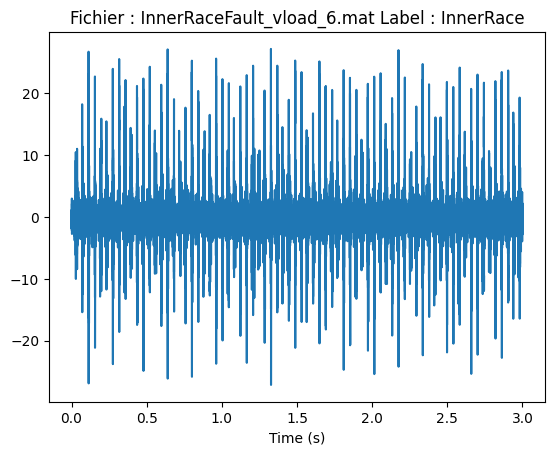

In [9]:
fn = eles[2]['metadata']['FileName'].decode()
sr = eles[2]['sampling_rate']
x = eles[2]['signal']['sig']
label=eles[2]['metadata']['Label'].decode()

plt.figure()
plt.plot(np.arange(len(x))/sr, x)
plt.xlabel('Time (s)')
plt.title('Fichier : '+fn+' Label : '+label)

Audio(x, rate=sr)

In [10]:
# Filter on the channels
channels = ['sig']

# Label ramification
keys = [] 

# Selection of domain
# filters = {'SensorType': [b'pin',b'po']}  # source domain
filters = {}  # no selection

# Resampling rate in Hz
resampling_rate = 48828  # no resampling

# Size of the sliding window (after resampling)
elem=list(ds0.take(5).as_numpy_iterator())
# window_size = resampling_rate  # 1 second
window_size = resampling_rate

# Number of samples to skip between sucessive window
hop_size = window_size//2

from dpmhm.datasets import transformer

compactor = transformer.DatasetCompactor(ds0, channels=channels, keys=keys, filters=filters,
                                         resampling_rate=resampling_rate, 
                                         window_size=window_size, hop_size=hop_size)

2024-06-11 11:39:40.077171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
ds1 = compactor.dataset

print("Original:", ds0.element_spec['signal'])
print("Compacted:", ds1.element_spec['signal'])

Original: {'sig': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}
Compacted: TensorSpec(shape=(1, None), dtype=tf.float32, name=None)


2024-06-11 11:39:42.046334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
eles0 = list(ds0.take(2).as_numpy_iterator())
eles1 = list(ds1.take(2).as_numpy_iterator())

ds1.element_spec

2024-06-11 11:39:42.098888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-11 11:39:42.209899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'label': TensorSpec(shape=(), dtype=tf.string, name=None),
 'sampling_rate': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'signal': TensorSpec(shape=(1, None), dtype=tf.float32, name=None)}

In [13]:
from dpmhm.datasets import feature

# Feature extractor

_func = lambda x, sr: feature.spectral_features(x, sr, 'spectrogram', 
                                                time_window=len(elem[0]['signal']['sig'])/resampling_rate, hop_step=len(elem[0]['signal']['sig'])/(resampling_rate*2), normalize=False,
                                                to_db=True)[0]
# _func = lambda x, sr: feature.spectral_features(x, sr, 'spectrogram', 
                                                # time_window=window_size/resampling_rate, hop_step=window_size/(resampling_rate*2), normalize=False,
                                                # to_db=True)[0]
                                                
# _func = lambda x, sr: feature.spectral_features(x, sr, 'melspectrogram', 
#                                                 time_window=0.025, hop_step=0.0125, normalize=False,
#                                                 feature_kwargs={'n_mels':128})[0]

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

In [14]:
ds2 = extractor.dataset
print(ds2.element_spec)

eles2 = list(ds2.take(2).as_numpy_iterator())

{'label': TensorSpec(shape=(), dtype=tf.string, name=None), 'feature': TensorSpec(shape=(1, None, None), dtype=tf.float32, name=None)}


/volatile/home/bm279471/Documents/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=262144 is too large for input signal of length=48828
  warnings.warn(
2024-06-11 11:39:42.484548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(1, 131073, 1)


Text(0, 0.5, 'Frequency bin')

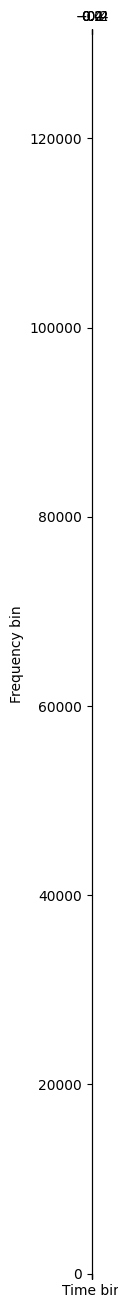

In [15]:
print(eles2[0]['feature'].shape)

X = eles2[0]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')